Given a spectrum and candidates, can we use the peak-to-node scores to extract key substructures?

- for each spectrum, look at top K candidates
- compute peak-to-node score matrix
- run DFS prioritizing node with high score to any peak, with predefined threshold T
- how often are they substructures?
- Find two examples where substructures extracted make up the target structure


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import pickle
import copy
from rdkit.Chem import Draw

# Load data and model

In [2]:
# model and dataset
import sys
sys.path.insert(0, "/data/yzhouc01/MassSpecGym")
sys.path.insert(0, "/data/yzhouc01/FILIP-MS")

from rdkit import RDLogger
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from massspecgym.models.base import Stage
import os

from flare.utils.data import get_spec_featurizer, get_mol_featurizer, get_ms_dataset
from flare.utils.models import get_model

from flare.definitions import TEST_RESULTS_DIR
import yaml
from functools import partial
# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Load model and data

param_pth = '/data/yzhouc01/FILIP-MS/experiments/20250913_optimized_filip-model/lightning_logs/version_0/hparams.yaml'
with open(param_pth) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

spec_featurizer = get_spec_featurizer(params['spectra_view'], params)
mol_featurizer = get_mol_featurizer(params['molecule_view'], params)
dataset = get_ms_dataset(params['spectra_view'], params['molecule_view'], spec_featurizer, mol_featurizer, params)


# load model
import torch 
checkpoint_pth = "/data/yzhouc01/FILIP-MS/experiments/20250913_optimized_filip-model/epoch=1993-train_loss=0.10.ckpt"
params['checkpoint_pth'] = checkpoint_pth
model = get_model(params['model'], params)

Data path:  /r/hassounlab/spectra_data/msgym/MassSpecGym.tsv
Processing formula spectra


100%|██████████| 231104/231104 [00:16<00:00, 14307.79it/s]
/data/yzhouc01/FILIP-MS/flare/data/datasets.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['spec'] = tmp_df.apply(lambda row: data_utils.make_tmp_subformula_spectra(row), axis=1)


Loaded Model from checkpoint


In [3]:
# annotation result
with open("/data/yzhouc01/FILIP-MS/experiments/20250913_optimized_filip-model/result_MassSpecGym_retrieval_candidates_formula.pkl", 'rb') as f:
    result = pickle.load(f)

In [ ]:
def get_target(candidates, labels):
    return np.array(candidates)[labels][0]

def sorted_candidates(candidates, scores):
    return np.array(candidates)[np.argsort(scores)[::-1]].tolist()

def get_n_heavy_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumHeavyAtoms()

def get_sorted_scores(scores):
    return np.array(scores)[np.argsort(scores)[::-1]].tolist()

result['target'] = result.apply(lambda x: get_target(x['candidates'], x['labels']), axis=1)

result['sorted_candidates'] = result.apply(lambda x: sorted_candidates(x['candidates'], x['scores']), axis=1)

result['n_heavy_atoms'] = result['target'].apply(get_n_heavy_atoms)

result['sorted_scores'] = result['scores'].apply(get_sorted_scores)

In [90]:
result.head(3)

identifier                                         candidates  \
0  MassSpecGymID0000201  [CC(C)[C@@H]1C(=O)N([C@H](C(=O)O[C@@H](C(=O)N(...   
1  MassSpecGymID0000202  [CC(C)[C@@H]1C(=O)N([C@H](C(=O)O[C@@H](C(=O)N(...   
2  MassSpecGymID0000203  [CC(C)[C@@H]1C(=O)N([C@H](C(=O)O[C@@H](C(=O)N(...   

                                              scores  \
0  [0.17369578778743744, 0.12611594796180725, 0.2...   
1  [0.05142267048358917, 0.07289629429578781, 0.1...   
2  [0.09354929625988007, 0.0947718694806099, 0.10...   

                                              labels  rank  \
0  [True, False, False, False, False, False, Fals...    17   
1  [True, False, False, False, False, False, Fals...    24   
2  [True, False, False, False, False, False, Fals...    23   

                                              target  \
0  CC(C)[C@@H]1C(=O)N([C@H](C(=O)O[C@@H](C(=O)N([...   
1  CC(C)[C@@H]1C(=O)N([C@H](C(=O)O[C@@H](C(=O)N([...   
2  CC(C)[C@@H]1C(=O)N([C@H](C(=O)O[C@@H](C(=O)N([...   

                                   sorted_candidates  n_heavy_atoms  \
0  [COCCCN1C(=O)COc2ccc(N(C(=O)[C@H]3CN(C(=O)OC(C...             57   
1  [COC(=O)/C(C)=C\CC1(O)C(=O)C2CC(C(C)C)C13Oc1c(...             57   
2  [C=CCOC12Oc3ccc(OC(=O)NCC)cc3C3C(CCCCO)C(CCCCO...             57   

                                       sorted_scores  
0  [0.2598780691623688, 0.2579679787158966, 0.249...  
1  [0.2371954619884491, 0.21642719209194183, 0.20...  
2  [0.2382681667804718, 0.22565233707427979, 0.21...

In [211]:
import torch.nn.functional as F

# Similarity matrix
def get_similarity_matrix(spec_enc, mol_enc):
    spec_enc =  F.normalize(spec_enc, p=2, dim=-1)
    mol_enc = F.normalize(mol_enc, p=2, dim=-1)
    
    similarity = torch.matmul(spec_enc, mol_enc.T).detach().cpu().numpy()
    sim_norm = (similarity - similarity.min()) / (similarity.max() - similarity.min() + 1e-8)
    
    return sim_norm

def get_embeds(ms_id, cand_smiles, model=model):

    i = dataset.metadata[dataset.metadata['identifier'] == ms_id].index[0]
    cand_mol= mol_featurizer(cand_smiles)

    # Embeddings
    model = model.to(torch.device('cpu'))
    model.eval()
    with torch.no_grad():
        input = copy.deepcopy(dataset[i])
        input['mol'] = cand_mol
        
        spec_enc, mol_enc = model.forward(input, stage='test')

    return spec_enc, mol_enc


def smiles_to_adjacency(smiles):
    """
    Convert SMILES -> adjacency dict {atom_idx: [neighbor_idx]} and RDKit Mol.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles!r}")
    adjacency = {i: [] for i in range(mol.GetNumAtoms())}
    for b in mol.GetBonds():
        a1 = b.GetBeginAtomIdx()
        a2 = b.GetEndAtomIdx()
        adjacency[a1].append(a2)
        adjacency[a2].append(a1)
    return adjacency, mol


def substructure_from_indices(smiles, indices):
    """
    Extract substructure as a valid Mol from atom indices.
    Works for disconnected fragments.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    
    indices = sorted(set(indices))
    if not indices:
        return None, None

    # Remove all atoms NOT in the fragment
    rw = Chem.RWMol(mol)
    remove = sorted(set(range(mol.GetNumAtoms())) - set(indices), reverse=True)
    for idx in remove:
        rw.RemoveAtom(idx)

    submol = rw.GetMol()
    # Chem.SanitizeMol(submol)  # ensures valid valence, kekulization, etc.
    # display(submol)
    
    subsmiles = Chem.MolToSmiles(submol, canonical=True)
    return submol, subsmiles


from collections import deque

def dfs_with_scores(start, adjacency, visited, relevant_nodes, node_scores):
    stack = [start]
    component = []
    while stack:
        node = stack.pop()
        if node not in visited and node in relevant_nodes:
            visited.add(node)
            component.append(node)
            # sort neighbors by score (high → low)
            neighbors = sorted(adjacency[node], key=lambda n: node_scores[n], reverse=True)
            stack.extend(neighbors)
    return component

def extract_substructures(score_matrix, adjacency, threshold):
    """
    score_matrix: np.array, shape (num_peaks, num_nodes)
    adjacency: dict {node: [neighbors]} representing molecular graph
    threshold: float
    
    Returns: list of substructures (list of node indices)
    """
    # Step 1: Overall node scores (max across peaks)
    # node_scores = score_matrix.max(axis=0)
    node_scores = score_matrix.max(axis=0)


    # Step 2: Relevant nodes (any score ≥ threshold)
    relevant_nodes = {j for j in range(score_matrix.shape[1]) 
                      if (score_matrix[:, j] >= threshold).any()}

    # Step 3: DFS traversal
    visited = set()
    substructures = []

    # sort relevant nodes by score for consistent traversal order
    sorted_nodes = sorted(relevant_nodes, key=lambda n: node_scores[n], reverse=True)

    for node in sorted_nodes:
        if node not in visited:
            comp = dfs_with_scores(node, adjacency, visited, relevant_nodes, node_scores)
            substructures.append(comp)

    return substructures



def bfs_with_scores(start, adjacency, visited, relevant_nodes, node_scores):
    """
    BFS traversal prioritizing neighbors by node score (high → low).
    """
    queue = deque([start])
    component = []
    
    while queue:
        node = queue.popleft()
        if node not in visited and node in relevant_nodes:
            visited.add(node)
            component.append(node)
            # sort neighbors by score (high → low)
            neighbors = sorted(adjacency[node], key=lambda n: node_scores[n], reverse=True)
            for nb in neighbors:
                if nb not in visited and nb in relevant_nodes:
                    queue.append(nb)
    return component


def extract_substructures_bfs(score_matrix, adjacency, threshold):
    """
    Extract relevant substructures using BFS.
    
    Args:
        score_matrix (np.ndarray): shape (num_peaks, num_nodes)
        adjacency (dict): {node: [neighbors]} molecular graph
        threshold (float): relevance threshold
    
    Returns:
        list[list[int]]: list of substructures (atom index lists)
    """
    # 1. Compute overall node scores
    node_scores = score_matrix.max(axis=0)

    # 2. Identify relevant nodes
    relevant_nodes = {j for j in range(score_matrix.shape[1])
                      if (score_matrix[:, j] >= threshold).any()}

    # 3. BFS over relevant nodes
    visited = set()
    substructures = []

    # Start with highest-scoring nodes
    sorted_nodes = sorted(relevant_nodes, key=lambda n: node_scores[n], reverse=True)

    for node in sorted_nodes:
        if node not in visited:
            comp = bfs_with_scores(node, adjacency, visited, relevant_nodes, node_scores)
            substructures.append(comp)

    return substructures



In [212]:

def main(ms_id, target_smiles, cand_smiles_list, cand_scores_list, walk_algo='dfs', threshold=0.5, peak_threshold=0.3):

    display(Chem.MolFromSmiles(target_smiles))
    mols = []
    legends = []
    for i, cand_smiles in enumerate(cand_smiles_list):

        # 1 Get embeddings
        spec_enc, mol_enc = get_embeds(ms_id, cand_smiles)

        # 2 compute score matrix
        score_matrix = get_similarity_matrix(spec_enc, mol_enc) # (num_peaks, num_nodes)

        # 2.5 eliminate some peaks??
        score_matrix = score_matrix[np.all(score_matrix > peak_threshold, axis=1)]

        # 3 traverse and extract
        adjacency, mol = smiles_to_adjacency(cand_smiles)

        mols.append(mol)
        legends.append(f"Cand@{i+1}({cand_scores_list[i]:.3})")

        if walk_algo == 'dfs':
            substructures_indecies = extract_substructures(score_matrix, adjacency, threshold)
        elif walk_algo == 'bfs':
            substructures_indecies = extract_substructures_bfs(score_matrix, adjacency, threshold)
        else:
            raise Exception("Walk algorithm not supported")

        j=0
        for j, indecies in enumerate(substructures_indecies[:2]):
            submol, sub_smiles = substructure_from_indices(cand_smiles, indecies)
            mols.append(submol)
            legends.append(f"submol_{i+1}{j}")

        while j<1:
            mols.append(None)
            legends.append('')
            j+=1

        if (i == 2) or (i==5):
            # Display candidate submols
            img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200), legends=legends)
            display(img)

            mols = []
            legends = []


MassSpecGymID0076675, t=0.75, rank=144


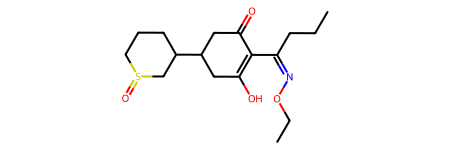

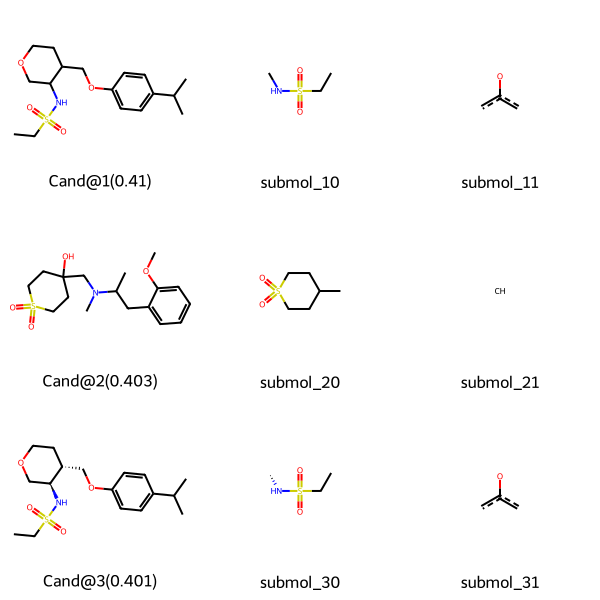

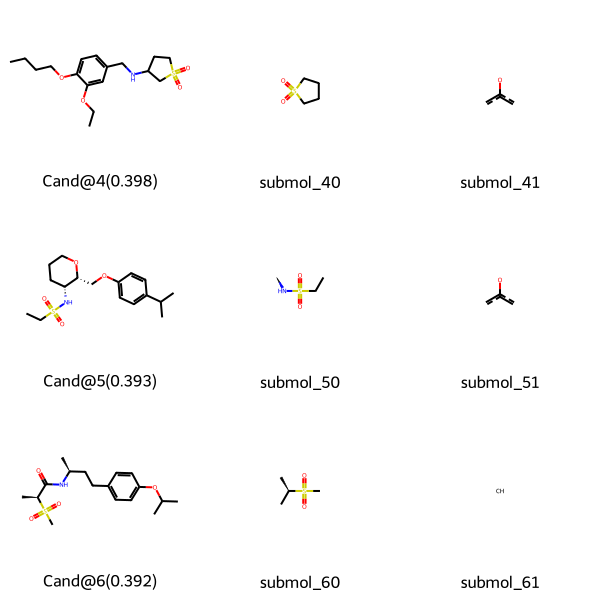

In [218]:
# ms_id = result[(result['n_heavy_atoms']<=25)& (result['rank']>20)].sample(1).iloc[0]['identifier']
ms_id = "MassSpecGymID0076675"
row = result[result['identifier'] == ms_id].iloc[0]
target_smiles = row['target']
cand_smiles_list = row['sorted_candidates'][0:6]
cand_scores_list = row['sorted_scores'][0:6]

threshold=0.75
print(f'{ms_id}, t={threshold}, rank={row["rank"]}')
main(ms_id, target_smiles, cand_smiles_list,cand_scores_list, walk_algo='dfs', threshold=threshold, peak_threshold=0.0)